#MS3
- Build a Deep Learning notebook
  - Build a deep learning model for the dataset
  - Investigate effects of mini-batch learning
  - Investigate effects of different optimizers
  - Tune hyperparameters (training testing and validation).  Explain conclusions about hyperparameters in colab markdown cells.


**Loading Data**

In [ ]:
#load dataset
import gdown
import pandas as pd
import os

file_id = "1wVHHFxZJ8AWwwXeD2BQs545AKZfwmlHN"
training_datapath = "cleaned_full_data.pkl"

if not os.path.exists(training_datapath):
    print("Downloading data from Google Drive...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", training_datapath, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1wVHHFxZJ8AWwwXeD2BQs545AKZfwmlHN
From (redirected): https://drive.google.com/uc?id=1wVHHFxZJ8AWwwXeD2BQs545AKZfwmlHN&confirm=t&uuid=89532339-75c2-4223-b66e-c13d715d8055
To: /content/cleaned_full_data.pkl
100%|██████████| 117M/117M [00:01<00:00, 59.4MB/s]


**Selected Features**

In [ ]:
included_columns = ["CASE_STATUS", "RECEIVED_DATE", "DECISION_DATE", "EMPLOYER_STATE_PROVINCE", "EMPLOYER_CITY", "WORKSITE_STATE", "WORKSITE_CITY", "COUNTRY_OF_CITIZENSHIP", "EMPLOYER_NUM_EMPLOYEES"]
training_data = pd.read_pickle(training_datapath)[included_columns]

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import keras_tuner as kt
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

In [ ]:
def getDays(datetime_val):
    if type(datetime_val) != datetime:
        return datetime_val
    return datetime_val.days
training_data["CASE_STATUS_FLAG"] = training_data["CASE_STATUS"].apply(lambda x: 1 if "Certified" == x else 0)
training_data['CASE_APPROVAL_LENGTH'] = training_data['DECISION_DATE'] - training_data['RECEIVED_DATE']
training_data['CASE_APPROVAL_LENGTH'] = training_data['CASE_APPROVAL_LENGTH'].apply(getDays)
for col in training_data.select_dtypes(include=['datetime64']).columns:
    training_data[col] = training_data[col].astype('int64') // 10**9
training_data = training_data.dropna()

**Gathering input and output data**

In [ ]:
#data
X_Logistic_Regression = training_data.drop(columns=['CASE_STATUS_FLAG', 'CASE_STATUS'], axis=1)  #drop target and related column
X_Logistic_Regression['CASE_APPROVAL_LENGTH'] = X_Logistic_Regression['CASE_APPROVAL_LENGTH'].dt.days
y_Logistic_Regression = training_data['CASE_STATUS_FLAG']  #target variable

#handle categorical variables by encoding them
label_encoders = {}
for column in X_Logistic_Regression.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_Logistic_Regression[column] = le.fit_transform(X_Logistic_Regression[column].astype(str))
    label_encoders[column] = le

**Setting up training, testing, and validation splits**

In [ ]:
#split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_Logistic_Regression,
    y_Logistic_Regression,
    test_size=0.2,
    random_state=42,
    stratify=y_Logistic_Regression
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=42,
    stratify=y_train_val
)
print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')

Training samples: 62738
Validation samples: 20913
Testing samples: 20913


# **Discussions on Train/Valid/Test Splits**
In this project, we empiprically implemented the commonly used splitting rules (Train:Valid:Test = 3:1:1) to avoid overfitting and underfitting. In detail, we downweight the percentage of the training set, and also let the validation set and test set to include the same num of samples. In such way, we observe that the model will converge quickly without andy overfit and underfit.




In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
def build_model(hp):
    model = Sequential()
    #tune the number of layers: 1 to 5
    for i in range(hp.Int('num_layers', 1, 5)):
        #tune the number of neurons: 32, 64, 128, 256
        units = hp.Choice(f'units_{i}', values=[32, 64, 128, 256])
        #tune the activation function: ReLU, Leaky ReLU, tanh
        activation = hp.Choice(f'activation_{i}', values=['relu', 'leaky_relu', 'tanh'])
        #add dense layer with activation
        if activation == 'leaky_relu':
            model.add(Dense(units, activation=None))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        else:
            model.add(Dense(units, activation=activation))
        #tune dropout rate: 0.2, 0.3, 0.5
        dropout_rate = hp.Choice(f'dropout_{i}', values=[0.2, 0.3, 0.5])
        model.add(Dropout(rate=dropout_rate))
    #output Layer
    model.add(Dense(1, activation='sigmoid'))
    #tune optimizer: Adam, RMSprop, SGD
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

    #tune learning rate
    if optimizer_choice == 'adam':
        learning_rate = hp.Float('adam_lr', 1e-4, 1e-2, sampling='log')
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        learning_rate = hp.Float('rmsprop_lr', 1e-4, 1e-2, sampling='log')
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        learning_rate = hp.Float('sgd_lr', 1e-4, 1e-2, sampling='log')
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    #compile the Model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

**Hyperparameter tuning**
- Testing the optimization method, number of layers, units per layer, activation functions, dropout rates, and learning rates.
- We use Keras Tuner's RandomSearch strategy to explore a defined search space, aiming to maximize validation accuracy.
- Two early stopping callbacks are used to prevent overfitting and save time.


In [ ]:
#initialize the Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='visa_prediction_tuning'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

early_stop_accuracy = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

#hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, early_stop_accuracy],
    verbose=1
)

#retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"  Layer {i+1}:")
    print(f"    Units: {best_hps.get(f'units_{i}')}")
    print(f"    Activation: {best_hps.get(f'activation_{i}')}")
    print(f"    Dropout Rate: {best_hps.get(f'dropout_{i}')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
if best_hps.get('optimizer') == 'adam':
    print(f"Learning Rate: {best_hps.get('adam_lr')}")
elif best_hps.get('optimizer') == 'rmsprop':
    print(f"Learning Rate: {best_hps.get('rmsprop_lr')}")
else:
    print(f"Learning Rate: {best_hps.get('sgd_lr')}")

Trial 20 Complete [00h 01m 00s]
val_accuracy: 0.9780040979385376

Best val_accuracy So Far: 0.9799885451793671
Total elapsed time: 00h 58m 38s

Best Hyperparameters:
Number of Layers: 5
  Layer 1:
    Units: 128
    Activation: relu
    Dropout Rate: 0.3
  Layer 2:
    Units: 128
    Activation: leaky_relu
    Dropout Rate: 0.2
  Layer 3:
    Units: 32
    Activation: relu
    Dropout Rate: 0.2
  Layer 4:
    Units: 128
    Activation: tanh
    Dropout Rate: 0.3
  Layer 5:
    Units: 128
    Activation: leaky_relu
    Dropout Rate: 0.3
Optimizer: adam
Learning Rate: 0.0006188360607938627


# **Discussions on effects of mini-batch learning, hyperparameters, and different optimizers**

In the above code cells, we conduct experiments on the effects of mini-batch learning, hyperparameters, and different optimiers together, where the SGD optimizer is actually an extreme case of mini-batch learning. We tried three different optimzers in our experiments: SGD, RMSprop, and Adam. Before experiments, we assume the Adam optimzer will be the most effective one, in that it is the most popular optimzier which is widely used in current ML/DL/CV/NLP researched.

Through our ablation experiment above, we the best optimizer is Adam, which is also aligned with our assumptions. Besids, we obtain the best set of hyperparameters:

Best Hyperparameters:
```
Number of Layers: 5
  Layer 1:
    Units: 128
    Activation: relu
    Dropout Rate: 0.3
  Layer 2:
    Units: 128
    Activation: leaky_relu
    Dropout Rate: 0.2
  Layer 3:
    Units: 32
    Activation: relu
    Dropout Rate: 0.2
  Layer 4:
    Units: 128
    Activation: tanh
    Dropout Rate: 0.3
  Layer 5:
    Units: 128
    Activation: leaky_relu
    Dropout Rate: 0.3
Optimizer: adam
Learning Rate: 0.0006188360607938627
```

With these, the accuracy of our model on the validation set in above cells, and the one on the test set in below cells are on the same level. This can help to demonstrate that our model works effectively.

In [ ]:
#build the Best Model
best_model = tuner.hypermodel.build(best_hps)
#train the Best Model
final_history = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest Accuracy: {accuracy*100:.2f}%')

Epoch 1/50
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9137 - loss: 0.2306 - val_accuracy: 0.9684 - val_loss: 0.0928
Epoch 2/50
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9665 - loss: 0.1041 - val_accuracy: 0.9747 - val_loss: 0.0775
Epoch 3/50
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9713 - loss: 0.0879 - val_accuracy: 0.9748 - val_loss: 0.0779
Epoch 4/50
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9720 - loss: 0.0850 - val_accuracy: 0.9772 - val_loss: 0.0727
Epoch 5/50
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9754 - loss: 0.0762 - val_accuracy: 0.9780 - val_loss: 0.0696
Epoch 6/50
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9758 - loss: 0.0763 - val_accuracy: 0.9773 - val_loss: 0.0683
Epoch 7/50
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9760 - loss: 0.0769 - val_accuracy: 0.9778 - val_loss: 0.0688
Epoch 8/50
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9766 - loss: 0.0751 -

In [ ]:
#predict Probabilities
y_pred_prob = best_model.predict(X_test)
#convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)

654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
#classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     12821
           1       0.95      0.99      0.97      8092

    accuracy                           0.98     20913
   macro avg       0.97      0.98      0.98     20913
weighted avg       0.98      0.98      0.98     20913



In [ ]:
#confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[12429   392]
 [   61  8031]]


**Plotting best model from hyperparameter tuning trained on validation**

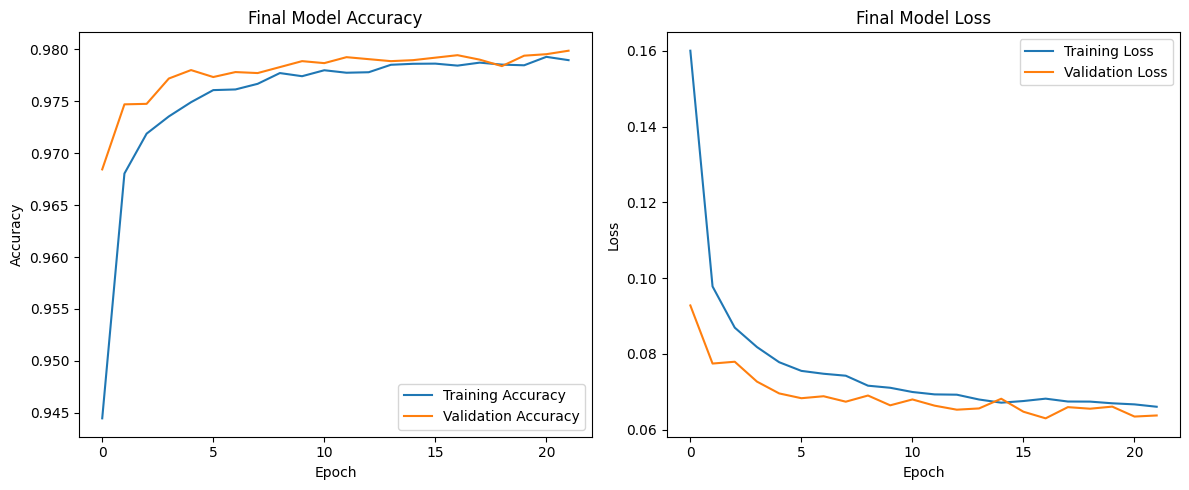

In [ ]:
#plot training & validation accuracy and loss for final model
plt.figure(figsize=(12,5))

#accuracy plot
plt.subplot(1,2,1)
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#loss plot
plt.subplot(1,2,2)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Plotting best model trained on testing data**

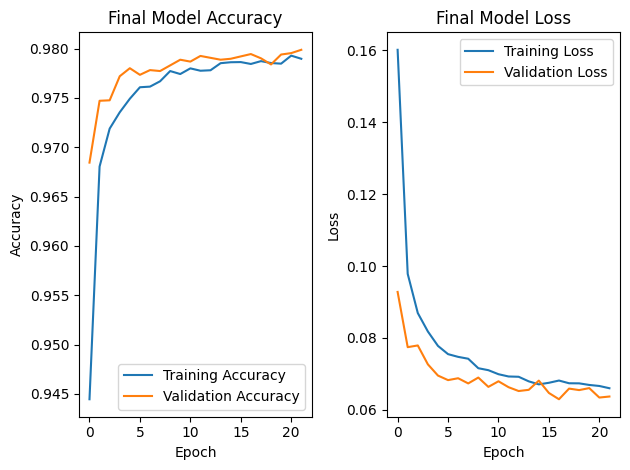

In [ ]:
#accuracy plot
plt.subplot(1,2,1)
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#loss plot
plt.subplot(1,2,2)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()